**Training model on the raw data with 3 layers and data split**

**Optimizer = Adam**

**Loss = binary_crossentropy**

# Folder Creation

In [10]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Load the trained model
model = tf.keras.models.load_model('F:/College/Years/B.Tech/Major_project/Model_resources/pest_and_insect_detection_model.h5')

# Define the path to the folder containing test images
test_image_dir = 'E:/Download/data/Categorized/Healthy'

# Get a list of image file names in the test folder
image_files = [f for f in os.listdir(test_image_dir) if os.path.isfile(os.path.join(test_image_dir, f))]

# Define a dictionary to map class indices to disease names
class_names = {0: 'Gumosis', 1: 'Healthy', 2: 'Red Rust'}

# Define the remedies dictionary
remedies = {
    "Gumosis": {
        "fungicides": ["Bordeaux mixture (1%)", "Copper oxychloride (0.3%)", "Mancozeb (0.3%)"],
        "other_treatments": ["Remove and destroy affected branches.", "Apply a copper-based fungicide to the cut surfaces.", "Apply a balanced fertilizer to the tree.", "Water the tree regularly, but avoid overwatering."]
    },
    "Healthy": {
        "preventive_measures": ["Plant cashew trees in well-drained soil.", "Avoid overwatering the trees.", "Apply a balanced fertilizer to the trees regularly.", "Inspect the trees regularly for pests and diseases."],
        "treatment_of_pests_and_diseases": ["Use fungicides and pesticides as needed.", "Remove and destroy affected branches.", "Apply copper-based fungicides to the cut surfaces."]
    },
    "Red Rust": {
        "fungicides": ["Bordeaux mixture (1%)", "Copper oxychloride (0.3%)", "Mancozeb (0.3%)"],
        "other_treatments": ["Remove and destroy affected leaves.", "Spray the tree with a copper-based fungicide.", "Apply a balanced fertilizer to the tree.", "Water the tree regularly, but avoid overwatering."]
    }
}

# Iterate through the test images and make predictions
for image_file in image_files:
    try:
        # Load and preprocess the test image
        img_path = os.path.join(test_image_dir, image_file)
        img = image.load_img(img_path, target_size=(400, 400))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0  # Rescale pixel values to [0, 1]

        # Make predictions
        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions, axis=1)[0]

        # Get the disease name from the dictionary
        detected_disease = class_names[predicted_class]

        # Get the remedies for the detected disease
        disease_remedies = remedies.get(detected_disease, {})
        fungicides = disease_remedies.get("fungicides", [])
        other_treatments = disease_remedies.get("other_treatments", [])

        # Create the destination folder if it doesn't exist
        destination_folder = os.path.join(test_image_dir, detected_disease)
        if not os.path.exists(destination_folder):
            os.makedirs(destination_folder)

        # Move the image to the respective disease category folder
        os.rename(img_path, os.path.join(destination_folder, image_file))

        # Create a text file with remedy information
        with open(os.path.join(destination_folder, f"{os.path.splitext(image_file)[0]}.txt"), 'w') as remedy_file:
            remedy_file.write(f"Detected Disease: {detected_disease}\n\nFungicides:\n{', '.join(fungicides)}\n\nOther Treatments:\n{', '.join(other_treatments)}")

    except Exception as e:
        print(f"Error processing {image_file}: {str(e)}")

# Print the counts of healthy and disease images
print(f"Healthy Images: {len(os.listdir(os.path.join(test_image_dir, 'Healthy')))}")
print(f"Gumosis Images: {len(os.listdir(os.path.join(test_image_dir, 'Gumosis')))}")
print(f"Red Rust Images: {len(os.listdir(os.path.join(test_image_dir, 'Red Rust')))}")


1/1 [==============================] - 0s 419ms/step
Healthy Images: 32
Gumosis Images: 28
Red Rust Images: 32


**Fine tunining the model**

# **Model training (Cashew)(best accuracy)**

In [22]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers, optimizers

# Set the image dimensions and other parameters
img_width, img_height = 400, 400
batch_size = 32
epochs = 10
num_classes = 3

# Set the data directory
data_dir = 'F:\College\Years\B.Tech\Major_project\Cashew'

# Data augmentation and other preprocessing for the training dataset
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,       # Additional data augmentation: rotation
    width_shift_range=0.2,   # Additional data augmentation: horizontal shift
    height_shift_range=0.2,  # Additional data augmentation: vertical shift
    validation_split=0.2     # Split data into training and validation sets
)

# Load the training and validation datasets with data augmentation
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Load the pre-trained VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the layers of the pre-trained VGG16 base to avoid overfitting
for layer in base_model.layers:
    layer.trainable = False

# Add new layers for our specific classification task
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs,
    callbacks=[early_stopping]
)

# Save the model
model.save('pest_and_insect_detection_model.h5')

# Evaluate the model on the testing set
test_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

loss, accuracy = model.evaluate(
    test_generator,
    steps=test_generator.samples // batch_size
)

print(f"Testing Accuracy: {accuracy}")


Found 2755 images belonging to 3 classes.
Found 687 images belonging to 3 classes.
Epoch 1/10
86/86 [==============================] - 1200s 14s/step - loss: 1.8112 - accuracy: 0.7822 - val_loss: 0.1952 - val_accuracy: 0.9405
Epoch 2/10
86/86 [==============================] - 1237s 14s/step - loss: 0.1732 - accuracy: 0.9372 - val_loss: 0.1488 - val_accuracy: 0.9509
Epoch 3/10
86/86 [==============================] - 1230s 14s/step - loss: 0.1839 - accuracy: 0.9317 - val_loss: 0.1107 - val_accuracy: 0.9643
Epoch 4/10
86/86 [==============================] - 1228s 14s/step - loss: 0.1655 - accuracy: 0.9346 - val_loss: 0.0874 - val_accuracy: 0.9747
Epoch 5/10
86/86 [==============================] - 1175s 14s/step - loss: 0.1592 - accuracy: 0.9416 - val_loss: 0.1116 - val_accuracy: 0.9598
Epoch 6/10
86/86 [==============================] - 1181s 14s/step - loss: 0.1218 - accuracy: 0.9603 - val_loss: 0.0600 - val_accuracy: 0.9807
Epoch 7/10
86/86 [==============================] - 1173s 1

C:\Users\ABHIJIT DESHPANDE\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Found 687 images belonging to 3 classes.
21/21 [==============================] - 231s 11s/step - loss: 0.0502 - accuracy: 0.9807
Testing Accuracy: 0.980654776096344


# Detected

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Load the trained model
model = tf.keras.models.load_model('F:/College/Years/B.Tech/Major_project/Model_resources/pest_and_insect_detection_model.h5')

# Define the path to the folder containing test images
test_image_dir = 'E:/Download/data/G'

# Get a list of image file names in the test folder
image_files = [f for f in os.listdir(test_image_dir) if os.path.isfile(os.path.join(test_image_dir, f))]

# Define a dictionary to map class indices to disease names
class_names = {0: 'Gumosis', 1: 'Healthy', 2: 'Red Rust'}

# Iterate through the test images and make predictions
for image_file in image_files:
    try:
        # Load and preprocess the test image
        img_path = os.path.join(test_image_dir, image_file)
        img = image.load_img(img_path, target_size=(400, 400))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0  # Rescale pixel values to [0, 1]

        # Make predictions
        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions, axis=1)[0]

        # Get the disease name from the dictionary
        detected_disease = class_names[predicted_class]

        # Print the result for each image
        print(f"Image: {image_file}, Detected Disease: {detected_disease}")
    
    except Exception as e:
        print(f"Error processing {image_file}: {str(e)}")


C:\Users\ABHIJIT DESHPANDE\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Casava training and testing Final 
bacteria, green, brown, health, mosaic

In [30]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import models, layers, optimizers
from sklearn.model_selection import train_test_split

# Set the image dimensions and other parameters
img_width, img_height = 224, 224
batch_size = 32
epochs = 50
num_classes = 4

# Set the data directory
data_dir = 'F:/College/Years/B.Tech/Major_project/Datasets/Dataset_for_Crop_Pest_and_Disease_Detection/Raw_Data/CCMT_Dataset/Cassava'

# Data augmentation and preprocessing for the training dataset
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.3,
    height_shift_range=0.2,
    validation_split=0.2
)

# Load the data and split into training and validation sets
data_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Load the MobileNetV2 model without the top (fully connected) layers
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the layers of the base MobileNetV2 model
for layer in base_model.layers:
    layer.trainable = False

# Add new layers for classification
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)
history = model.fit(
    data_generator,
    steps_per_epoch=data_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs,
    callbacks=[early_stopping]
)

# Save the model
model.save('Cassava_MobileNet_model.h5')

# Evaluate the model on the testing set
test_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

loss, accuracy = model.evaluate(
    test_generator,
    steps=test_generator.samples // batch_size
)

print(f"Testing Accuracy: {accuracy}")


Found 4878 images belonging to 4 classes.
Found 1217 images belonging to 4 classes.
Epoch 1/50
152/152 [==============================] - 164s 1s/step - loss: 0.7391 - accuracy: 0.7134 - val_loss: 0.5325 - val_accuracy: 0.7928
Epoch 2/50
152/152 [==============================] - 114s 750ms/step - loss: 0.5024 - accuracy: 0.8062 - val_loss: 0.5923 - val_accuracy: 0.7484
Epoch 3/50
152/152 [==============================] - 113s 745ms/step - loss: 0.4553 - accuracy: 0.8203 - val_loss: 0.5142 - val_accuracy: 0.7862
Epoch 4/50
152/152 [==============================] - 113s 743ms/step - loss: 0.4175 - accuracy: 0.8405 - val_loss: 0.4837 - val_accuracy: 0.8109
Epoch 5/50
152/152 [==============================] - 113s 741ms/step - loss: 0.4051 - accuracy: 0.8487 - val_loss: 0.4672 - val_accuracy: 0.8191
Epoch 6/50
152/152 [==============================] - 118s 776ms/step - loss: 0.3998 - accuracy: 0.8434 - val_loss: 0.4676 - val_accuracy: 0.8166
Epoch 7/50
152/152 [=======================

C:\Users\ABHIJIT DESHPANDE\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Found 1217 images belonging to 4 classes.
38/38 [==============================] - 22s 584ms/step - loss: 0.4302 - accuracy: 0.8380
Testing Accuracy: 0.8379934430122375


In [32]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Load the trained model
model = tf.keras.models.load_model('MobileNet_model.h5')

# Define the path to the folder containing test images
test_image_dir = 'E:/Download/data/C'

# Get a list of image file names in the test folder
image_files = [f for f in os.listdir(test_image_dir) if os.path.isfile(os.path.join(test_image_dir, f))]

# Define a dictionary to map class indices to disease names
class_names = {0: 'bacterial blight', 1: 'Brown Spot', 2: 'Green mit', 3:'healthy', 4:'mosaic'}

# Iterate through the test images and make predictions
for image_file in image_files:
    try:
        # Load and preprocess the test image
        img_path = os.path.join(test_image_dir, image_file)
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0  # Rescale pixel values to [0, 1]

        # Make predictions
        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions, axis=1)[0]

        # Get the disease name from the dictionary
        detected_disease = class_names[predicted_class]

        # Print the result for each image
        print(f"Image: {image_file}, Detected Disease: {detected_disease}")
    
    except Exception as e:
        print(f"Error processing {image_file}: {str(e)}")

1/1 [==============================] - 1s 633ms/step
Image: bacterial blight10_.jpg, Detected Disease: bacterial blight
1/1 [==============================] - 0s 46ms/step
Image: bacterial blight11_.jpg, Detected Disease: healthy
1/1 [==============================] - 0s 48ms/step
Image: bacterial blight12_.jpg, Detected Disease: healthy
1/1 [==============================] - 0s 48ms/step
Image: bacterial blight13_.jpg, Detected Disease: Brown Spot
1/1 [==============================] - 0s 49ms/step
Image: bacterial blight14_.jpg, Detected Disease: healthy
1/1 [==============================] - 0s 51ms/step
Image: bacterial blight15_.jpg, Detected Disease: healthy
1/1 [==============================] - 0s 43ms/step
Image: bacterial blight16_.jpg, Detected Disease: healthy
1/1 [==============================] - 0s 46ms/step
Image: bacterial blight17_.jpg, Detected Disease: healthy
1/1 [==============================] - 0s 47ms/step
Image: bacterial blight18_.jpg, Detected Disease: healt

1/1 [==============================] - 0s 47ms/step
Image: brown spot25_.jpg, Detected Disease: bacterial blight
1/1 [==============================] - 0s 52ms/step
Image: brown spot26_.jpg, Detected Disease: healthy
1/1 [==============================] - 0s 44ms/step
Image: brown spot27_.jpg, Detected Disease: mosaic
1/1 [==============================] - 0s 44ms/step
Image: brown spot28_.jpg, Detected Disease: Brown Spot
1/1 [==============================] - 0s 46ms/step
Image: brown spot29_.jpg, Detected Disease: bacterial blight
1/1 [==============================] - 0s 49ms/step
Image: brown spot2_.jpg, Detected Disease: healthy
1/1 [==============================] - 0s 43ms/step
Image: brown spot30_.jpg, Detected Disease: bacterial blight
1/1 [==============================] - 0s 45ms/step
Image: brown spot31_.jpg, Detected Disease: healthy
1/1 [==============================] - 0s 55ms/step
Image: brown spot32_.jpg, Detected Disease: healthy
1/1 [==============================]

1/1 [==============================] - 0s 42ms/step
Image: green mite42_.jpg, Detected Disease: bacterial blight
1/1 [==============================] - 0s 45ms/step
Image: green mite43_.jpg, Detected Disease: bacterial blight
1/1 [==============================] - 0s 47ms/step
Image: green mite44_.jpg, Detected Disease: bacterial blight
1/1 [==============================] - 0s 44ms/step
Image: green mite45_.jpg, Detected Disease: bacterial blight
1/1 [==============================] - 0s 48ms/step
Image: green mite46_.jpg, Detected Disease: healthy
1/1 [==============================] - 0s 45ms/step
Image: green mite47_.jpg, Detected Disease: Green mit
1/1 [==============================] - 0s 53ms/step
Image: green mite48_.jpg, Detected Disease: bacterial blight
1/1 [==============================] - 0s 51ms/step
Image: green mite49_.jpg, Detected Disease: bacterial blight
1/1 [==============================] - 0s 47ms/step
Image: green mite4_.jpg, Detected Disease: bacterial blight


1/1 [==============================] - 0s 42ms/step
Image: healthy7_.jpg, Detected Disease: bacterial blight
1/1 [==============================] - 0s 47ms/step
Image: healthy8_.jpg, Detected Disease: bacterial blight
1/1 [==============================] - 0s 47ms/step
Image: healthy9_.jpg, Detected Disease: bacterial blight
1/1 [==============================] - 0s 37ms/step
Image: mosaic10_.jpg, Detected Disease: healthy
1/1 [==============================] - 0s 38ms/step
Image: mosaic11_.jpg, Detected Disease: bacterial blight
1/1 [==============================] - 0s 41ms/step
Image: mosaic12_.jpg, Detected Disease: bacterial blight
1/1 [==============================] - 0s 44ms/step
Image: mosaic13_.jpg, Detected Disease: bacterial blight
1/1 [==============================] - 0s 43ms/step
Image: mosaic20_.jpg, Detected Disease: Green mit
1/1 [==============================] - 0s 43ms/step
Image: mosaic21_.jpg, Detected Disease: healthy
1/1 [==============================] - 0s 44

In [29]:
from PIL import Image
import os

# Set the input and output directory paths
input_dir = 'F:/College/Years/B.Tech/Major_project/Datasets/Dataset_for_Crop_Pest_and_Disease_Detection/Raw_Data/CCMT_Dataset/Cassava/mosaic'
output_dir = 'F:/College/Years/B.Tech/Major_project/Datasets/Dataset_for_Crop_Pest_and_Disease_Detection/Raw_Data/CCMT_Dataset/Cassava/mosaic'

# Ensure the output directory exists, or create it if necessary
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Define the target size
target_size = (224, 224)

# Loop through each image file in the input directory
for filename in os.listdir(input_dir):
    if filename.endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):  # Add more file extensions if needed
        try:
            # Open the image file
            with Image.open(os.path.join(input_dir, filename)) as img:
                # Resize the image to the target size
                img_resized = img.resize(target_size)

                # Save the resized image to the output directory
                output_path = os.path.join(output_dir, filename)
                img_resized.save(output_path)

                print(f"Resized {filename} to {target_size}")
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")


Resized mosaic1000_.jpg to (224, 224)
Resized mosaic1001_.jpg to (224, 224)
Resized mosaic1002_.jpg to (224, 224)
Resized mosaic1003_.jpg to (224, 224)
Resized mosaic1004_.jpg to (224, 224)
Resized mosaic1005_.jpg to (224, 224)
Resized mosaic1006_.jpg to (224, 224)
Resized mosaic1007_.jpg to (224, 224)
Resized mosaic1008_.jpg to (224, 224)
Resized mosaic1009_.jpg to (224, 224)
Resized mosaic100_.jpg to (224, 224)
Resized mosaic1010_.jpg to (224, 224)
Resized mosaic1011_.jpg to (224, 224)
Resized mosaic1012_.jpg to (224, 224)
Resized mosaic1013_.jpg to (224, 224)
Resized mosaic1014_.jpg to (224, 224)
Resized mosaic1015_.jpg to (224, 224)
Resized mosaic1016_.jpg to (224, 224)
Resized mosaic1017_.jpg to (224, 224)
Resized mosaic1018_.jpg to (224, 224)
Resized mosaic1019_.jpg to (224, 224)
Resized mosaic101_.jpg to (224, 224)
Resized mosaic1020_.jpg to (224, 224)
Resized mosaic1021_.jpg to (224, 224)
Resized mosaic1022_.jpg to (224, 224)
Resized mosaic1023_.jpg to (224, 224)
Resized mosaic

Resized mosaic1198_.jpg to (224, 224)
Resized mosaic1199_.jpg to (224, 224)
Resized mosaic119_.jpg to (224, 224)
Resized mosaic11_.jpg to (224, 224)
Resized mosaic1200_.jpg to (224, 224)
Resized mosaic1201_.jpg to (224, 224)
Resized mosaic1202_.jpg to (224, 224)
Resized mosaic1203_.jpg to (224, 224)
Resized mosaic1204_.jpg to (224, 224)
Resized mosaic1205_.jpg to (224, 224)
Resized mosaic1206_.jpg to (224, 224)
Resized mosaic120_.jpg to (224, 224)
Resized mosaic121_.jpg to (224, 224)
Resized mosaic122_.jpg to (224, 224)
Resized mosaic123_.jpg to (224, 224)
Resized mosaic124_.jpg to (224, 224)
Resized mosaic125_.jpg to (224, 224)
Resized mosaic126_.jpg to (224, 224)
Resized mosaic127_.jpg to (224, 224)
Resized mosaic128_.jpg to (224, 224)
Resized mosaic129_.jpg to (224, 224)
Resized mosaic12_.jpg to (224, 224)
Resized mosaic130_.jpg to (224, 224)
Resized mosaic131_.jpg to (224, 224)
Resized mosaic132_.jpg to (224, 224)
Resized mosaic133_.jpg to (224, 224)
Resized mosaic134_.jpg to (224,

Resized mosaic315_.jpg to (224, 224)
Resized mosaic316_.jpg to (224, 224)
Resized mosaic317_.jpg to (224, 224)
Resized mosaic318_.jpg to (224, 224)
Resized mosaic319_.jpg to (224, 224)
Resized mosaic31_.jpg to (224, 224)
Resized mosaic320_.jpg to (224, 224)
Resized mosaic321_.jpg to (224, 224)
Resized mosaic322_.jpg to (224, 224)
Resized mosaic323_.jpg to (224, 224)
Resized mosaic324_.jpg to (224, 224)
Resized mosaic325_.jpg to (224, 224)
Resized mosaic326_.jpg to (224, 224)
Resized mosaic327_.jpg to (224, 224)
Resized mosaic328_.jpg to (224, 224)
Resized mosaic329_.jpg to (224, 224)
Resized mosaic32_.jpg to (224, 224)
Resized mosaic330_.jpg to (224, 224)
Resized mosaic331_.jpg to (224, 224)
Resized mosaic332_.jpg to (224, 224)
Resized mosaic333_.jpg to (224, 224)
Resized mosaic334_.jpg to (224, 224)
Resized mosaic335_.jpg to (224, 224)
Resized mosaic336_.jpg to (224, 224)
Resized mosaic337_.jpg to (224, 224)
Resized mosaic338_.jpg to (224, 224)
Resized mosaic339_.jpg to (224, 224)
Res

Resized mosaic51_.jpg to (224, 224)
Resized mosaic520_.jpg to (224, 224)
Resized mosaic521_.jpg to (224, 224)
Resized mosaic522_.jpg to (224, 224)
Resized mosaic523_.jpg to (224, 224)
Resized mosaic524_.jpg to (224, 224)
Resized mosaic525_.jpg to (224, 224)
Resized mosaic526_.jpg to (224, 224)
Resized mosaic527_.jpg to (224, 224)
Resized mosaic528_.jpg to (224, 224)
Resized mosaic529_.jpg to (224, 224)
Resized mosaic52_.jpg to (224, 224)
Resized mosaic530_.jpg to (224, 224)
Resized mosaic531_.jpg to (224, 224)
Resized mosaic532_.jpg to (224, 224)
Resized mosaic533_.jpg to (224, 224)
Resized mosaic534_.jpg to (224, 224)
Resized mosaic535_.jpg to (224, 224)
Resized mosaic536_.jpg to (224, 224)
Resized mosaic537_.jpg to (224, 224)
Resized mosaic538_.jpg to (224, 224)
Resized mosaic539_.jpg to (224, 224)
Resized mosaic53_.jpg to (224, 224)
Resized mosaic540_.jpg to (224, 224)
Resized mosaic541_.jpg to (224, 224)
Resized mosaic542_.jpg to (224, 224)
Resized mosaic543_.jpg to (224, 224)
Resi

Resized mosaic728_.jpg to (224, 224)
Resized mosaic729_.jpg to (224, 224)
Resized mosaic72_.jpg to (224, 224)
Resized mosaic730_.jpg to (224, 224)
Resized mosaic731_.jpg to (224, 224)
Resized mosaic732_.jpg to (224, 224)
Resized mosaic733_.jpg to (224, 224)
Resized mosaic734_.jpg to (224, 224)
Resized mosaic735_.jpg to (224, 224)
Resized mosaic736_.jpg to (224, 224)
Resized mosaic737_.jpg to (224, 224)
Resized mosaic738_.jpg to (224, 224)
Resized mosaic739_.jpg to (224, 224)
Resized mosaic73_.jpg to (224, 224)
Resized mosaic740_.jpg to (224, 224)
Resized mosaic741_.jpg to (224, 224)
Resized mosaic742_.jpg to (224, 224)
Resized mosaic743_.jpg to (224, 224)
Resized mosaic744_.jpg to (224, 224)
Resized mosaic745_.jpg to (224, 224)
Resized mosaic746_.jpg to (224, 224)
Resized mosaic747_.jpg to (224, 224)
Resized mosaic748_.jpg to (224, 224)
Resized mosaic749_.jpg to (224, 224)
Resized mosaic74_.jpg to (224, 224)
Resized mosaic750_.jpg to (224, 224)
Resized mosaic751_.jpg to (224, 224)
Resi

Resized mosaic929_.jpg to (224, 224)
Resized mosaic92_.jpg to (224, 224)
Resized mosaic930_.jpg to (224, 224)
Resized mosaic931_.jpg to (224, 224)
Resized mosaic932_.jpg to (224, 224)
Resized mosaic933_.jpg to (224, 224)
Resized mosaic934_.jpg to (224, 224)
Resized mosaic935_.jpg to (224, 224)
Resized mosaic936_.jpg to (224, 224)
Resized mosaic937_.jpg to (224, 224)
Resized mosaic938_.jpg to (224, 224)
Resized mosaic939_.jpg to (224, 224)
Resized mosaic93_.jpg to (224, 224)
Resized mosaic940_.jpg to (224, 224)
Resized mosaic941_.jpg to (224, 224)
Resized mosaic942_.jpg to (224, 224)
Resized mosaic943_.jpg to (224, 224)
Resized mosaic944_.jpg to (224, 224)
Resized mosaic945_.jpg to (224, 224)
Resized mosaic946_.jpg to (224, 224)
Resized mosaic947_.jpg to (224, 224)
Resized mosaic948_.jpg to (224, 224)
Resized mosaic949_.jpg to (224, 224)
Resized mosaic94_.jpg to (224, 224)
Resized mosaic950_.jpg to (224, 224)
Resized mosaic951_.jpg to (224, 224)
Resized mosaic952_.jpg to (224, 224)
Resi

# Maize Training

In [14]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers, optimizers

# Set the image dimensions and other parameters
img_width, img_height = 224, 224
batch_size = 32
epochs = 10
num_classes = 5

# Set the data directory
data_dir = 'F:/College/Years/B.Tech/Major_project/Datasets/Dataset_for_Crop_Pest_and_Disease_Detection/Maize'  # Replace with the actual path

# Data augmentation and other preprocessing for the training dataset
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2
)

# Load the training and validation datasets with data augmentation
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Load the pre-trained VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the layers of the pre-trained VGG16 base to avoid overfitting
for layer in base_model.layers:
    layer.trainable = False

# Add new layers for our specific classification task
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs,
    callbacks=[early_stopping]
)

# Save the model
model.save('maize_detection_model.h5')


Found 1667 images belonging to 5 classes.
Found 416 images belonging to 5 classes.
Epoch 1/10
52/52 [==============================] - 214s 4s/step - loss: 1.5275 - accuracy: 0.5425 - val_loss: 0.9206 - val_accuracy: 0.6202
Epoch 2/10
52/52 [==============================] - 214s 4s/step - loss: 0.7526 - accuracy: 0.7205 - val_loss: 0.8162 - val_accuracy: 0.7091
Epoch 3/10
52/52 [==============================] - 214s 4s/step - loss: 0.6557 - accuracy: 0.7572 - val_loss: 0.7643 - val_accuracy: 0.6971
Epoch 4/10
52/52 [==============================] - 215s 4s/step - loss: 0.6341 - accuracy: 0.7596 - val_loss: 0.7686 - val_accuracy: 0.6875
Epoch 5/10
52/52 [==============================] - 215s 4s/step - loss: 0.6063 - accuracy: 0.7725 - val_loss: 0.7557 - val_accuracy: 0.6995
Epoch 6/10
52/52 [==============================] - 218s 4s/step - loss: 0.5810 - accuracy: 0.8006 - val_loss: 0.7336 - val_accuracy: 0.7380
Epoch 7/10
52/52 [==============================] - 220s 4s/step - loss

C:\Users\ABHIJIT DESHPANDE\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Maize Testing

In [27]:
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Load the trained model
model = load_model('maize_detection_model.h5')

# Load the test dataset with only the "healthy" category
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    'F:/College/Years/B.Tech/Major_project/Datasets/Dataset_for_Crop_Pest_and_Disease_Detection/Raw_Data/Health',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Evaluate the model on the "healthy" test dataset
loss, accuracy = model.evaluate(
    test_generator,
    steps=test_generator.samples // batch_size
)

print(f"Maize Testing Accuracy: {accuracy}")

# Get the true labels
true_labels = test_generator.classes

# Get the predicted labels
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
print(cm)


Found 5943 images belonging to 5 classes.
185/185 [==============================] - 659s 4s/step - loss: 0.4988 - accuracy: 0.8304
Testing Accuracy: 0.8304054141044617
186/186 [==============================] - 719s 4s/step
Confusion Matrix:
[[ 81  93  46 160 186]
 [151 198  99 321 315]
 [ 59  81  41 118 118]
 [245 356 154 548 579]
 [275 346 161 603 609]]


# Tomato training

In [34]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import models, layers, optimizers
from sklearn.model_selection import train_test_split

# Set the image dimensions and other parameters
img_width, img_height = 200, 200
batch_size = 32
epochs = 50
num_classes = 5

# Set the data directory
data_dir = 'F:/College/Years/B.Tech/Major_project/Datasets/Dataset_for_Crop_Pest_and_Disease_Detection/CCMT_Dataset-Augmented/Tomato/train_set'

# Data augmentation and preprocessing for the training dataset
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.3,
    height_shift_range=0.2,
    validation_split=0.4
)

# Load the data and split into training and validation sets
data_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Load the MobileNetV2 model without the top (fully connected) layers
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the layers of the base MobileNetV2 model
for layer in base_model.layers:
    layer.trainable = False

# Add new layers for classification
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)
history = model.fit(
    data_generator,
    steps_per_epoch=data_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs,
    callbacks=[early_stopping]
)

# Save the model
model.save('Tomato_MobileNet_model.h5')

# Evaluate the model on the testing set
test_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

loss, accuracy = model.evaluate(
    test_generator,
    steps=test_generator.samples // batch_size
)

print(f"Testing Accuracy: {accuracy}")


Found 13034 images belonging to 5 classes.
Found 8689 images belonging to 5 classes.
Epoch 1/50
407/407 [==============================] - 492s 1s/step - loss: 1.2181 - accuracy: 0.4905 - val_loss: 1.1513 - val_accuracy: 0.5035
Epoch 2/50
407/407 [==============================] - 307s 754ms/step - loss: 1.1023 - accuracy: 0.5329 - val_loss: 1.1056 - val_accuracy: 0.5167
Epoch 3/50
407/407 [==============================] - 309s 759ms/step - loss: 1.0569 - accuracy: 0.5507 - val_loss: 1.1122 - val_accuracy: 0.5271
Epoch 4/50
407/407 [==============================] - 309s 761ms/step - loss: 1.0489 - accuracy: 0.5555 - val_loss: 1.0833 - val_accuracy: 0.5411
Epoch 5/50
407/407 [==============================] - 308s 757ms/step - loss: 1.0258 - accuracy: 0.5688 - val_loss: 1.0845 - val_accuracy: 0.5366
Epoch 6/50
407/407 [==============================] - 332s 817ms/step - loss: 1.0106 - accuracy: 0.5788 - val_loss: 1.0919 - val_accuracy: 0.5277
Epoch 7/50
407/407 [======================

# Tomato Testing

In [32]:
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Load the trained model
model = load_model('MobileNet_model.h5')

# Load the test dataset with only the "healthy" category
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    'F:/College/Years/B.Tech/Major_project/Datasets/Dataset_for_Crop_Pest_and_Disease_Detection/Raw_Data/CCMT_Dataset/Cassava',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Evaluate the model on the "healthy" test dataset
loss, accuracy = model.evaluate(
    test_generator,
    steps=test_generator.samples // batch_size
)

print(f"Maize Testing Accuracy: {accuracy}")

# Get the true labels
true_labels = test_generator.classes

# Get the predicted labels
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
print(cm)


Found 7508 images belonging to 5 classes.
234/234 [==============================] - 122s 519ms/step - loss: 0.2476 - accuracy: 0.9061
Maize Testing Accuracy: 0.9061164259910583
235/235 [==============================] - 123s 519ms/step
Confusion Matrix:
[[1057  430  304  420  403]
 [ 586  247  201  226  221]
 [ 410  177  115  152  161]
 [ 451  219  150  193  180]
 [ 447  237  150  188  183]]


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers, optimizers

# Set the image dimensions and other parameters
img_width, img_height = 400, 400
batch_size = 24
epochs = 10
num_classes = 5

# Set the data directory
data_dir = 'F:/College/Years/B.Tech/Major_project/Datasets/Dataset_for_Crop_Pest_and_Disease_Detection/Check/tomato'

# Data augmentation and other preprocessing for the training dataset
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,       # Additional data augmentation: rotation
    width_shift_range=0.2,   # Additional data augmentation: horizontal shift
    height_shift_range=0.2,  # Additional data augmentation: vertical shift
    validation_split=0.2     # Split data into training and validation sets
)

# Load the training and validation datasets with data augmentation
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Load the pre-trained VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the layers of the pre-trained VGG16 base to avoid overfitting
for layer in base_model.layers:
    layer.trainable = False

# Add new layers for our specific classification task
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs,
    callbacks=[early_stopping]
)

# Save the model
model.save('tomato_model.h5')

# Evaluate the model on the testing set
test_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

loss, accuracy = model.evaluate(
    test_generator,
    steps=test_generator.samples // batch_size
)

print(f"Tomato Testing Accuracy: {accuracy}")


Found 2630 images belonging to 5 classes.
Found 653 images belonging to 5 classes.
Epoch 1/10
109/109 [==============================] - 1231s 11s/step - loss: 2.8368 - accuracy: 0.2437 - val_loss: 1.6014 - val_accuracy: 0.2639
Epoch 2/10
109/109 [==============================] - 1222s 11s/step - loss: 1.5992 - accuracy: 0.2824 - val_loss: 1.5898 - val_accuracy: 0.2840
Epoch 3/10
109/109 [==============================] - 53652s 497s/step - loss: 1.5920 - accuracy: 0.2728 - val_loss: 1.5816 - val_accuracy: 0.2855
Epoch 4/10
109/109 [==============================] - 1245s 11s/step - loss: 1.5830 - accuracy: 0.2832 - val_loss: 1.5766 - val_accuracy: 0.2840
Epoch 5/10
 24/109 [=====>........................] - ETA: 12:21 - loss: 1.5791 - accuracy: 0.2951

# Tomato testing

In [37]:
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Load the trained model
model = load_model('maize_detection_model.h5')

# Load the test dataset with only the "healthy" category
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    'F:/College/Years/B.Tech/Major_project/Datasets/Dataset_for_Crop_Pest_and_Disease_Detection/CCMT_Dataset-Augmented/Tomato/test_set',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Evaluate the model on the "healthy" test dataset
loss, accuracy = model.evaluate(
    test_generator,
    steps=test_generator.samples // batch_size
)

print(f"Tomato Testing Accuracy: {accuracy}")

# Get the true labels
true_labels = test_generator.classes

# Get the predicted labels
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
print(cm)


Found 5445 images belonging to 5 classes.
170/170 [==============================] - 608s 4s/step - loss: 5.2640 - accuracy: 0.1147
Tomato Testing Accuracy: 0.1147058829665184
171/171 [==============================] - 633s 4s/step
Confusion Matrix:
[[ 177   16    7    9  291]
 [ 463   54   26   16  750]
 [ 186   15   13    6  312]
 [ 893   66   37   26 1318]
 [ 279   28   15   12  430]]


# Plotting the graph

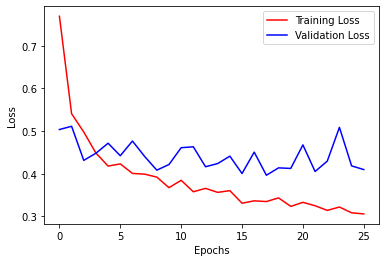

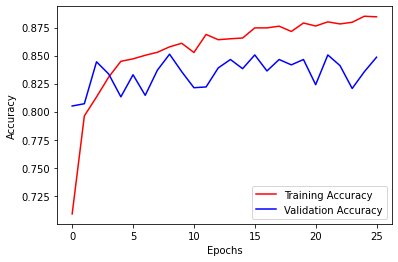

In [33]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy', color='red')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [30]:
import os
from PIL import Image

def is_valid_image(image_path):
    try:
        with Image.open(image_path) as img:
            img.verify()
            return True
    except Exception as e:
        print(f"Error: {e} for image: {image_path}")
        return False

def remove_broken_images(data_dir):
    for root, _, files in os.walk(data_dir):
        for file in files:
            image_path = os.path.join(root, file)
            if not is_valid_image(image_path):
                os.remove(image_path)
                print(f"Removed {image_path} (broken image)")

# Set the data directory
data_dir = 'F:/College/Years/B.Tech/Major_project/Datasets/Dataset_for_Crop_Pest_and_Disease_Detection/Raw_Data/Tomato'  # Replace with the path to your data directory
remove_broken_images(data_dir)


# Confusion matrix

In [31]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix

# Set the image dimensions and other parameters
img_width, img_height = 224, 224
batch_size = 32

# Set the data directory for the 2 classes you want to test on
test_data_dir = 'F:/College/Years/B.Tech/Major_project/Datasets/Dataset_for_Crop_Pest_and_Disease_Detection/Raw_Data/Health'  # Replace with the path to the new test directory

# Load the trained model
model = load_model('maize_detection_model.h5')  # Replace with the path to your trained model

# Create the test data generator for the 2 classes
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Evaluate the model on the new test dataset
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Compute confusion matrix
confusion = confusion_matrix(true_classes, predicted_classes)

print(predicted_classes)
print(true_classes)
# Calculate accuracy manually
#correct_predictions = np.sum(predicted_classes == true_classes)
#total_samples = len(true_classes)
#accuracy = correct_predictions / total_samples

print("Confusion Matrix:")
print(confusion)




Found 5943 images belonging to 5 classes.
186/186 [==============================] - 1299s 7s/step
[4 4 3 ... 4 3 2]
[0 0 0 ... 4 4 4]
Confusion Matrix:
[[ 77 103  44 174 168]
 [139 185  79 319 362]
 [ 47  77  35 115 143]
 [281 341 183 547 530]
 [267 368 160 595 604]]


In [33]:
from sklearn.metrics import classification_report

# Calculate precision, recall, and F1-score for each class
report = classification_report(true_classes, predicted_classes)
print(report)

              precision    recall  f1-score   support

           0       0.09      0.14      0.11       566
           1       0.17      0.17      0.17      1084
           2       0.07      0.08      0.08       417
           3       0.31      0.29      0.30      1882
           4       0.33      0.30      0.32      1994

    accuracy                           0.24      5943
   macro avg       0.20      0.20      0.20      5943
weighted avg       0.26      0.24      0.25      5943



In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

# Assuming true_classes and predicted_classes are the true and predicted class labels
# true_classes = test_generator.classes
# predicted_classes = model.predict_classes(test_generator)

# Choose the class index for which you want to assess accuracy
target_class = 4 # Replace with the index of the class you want to evaluate

# Create a binary vector indicating if the true class matches the target class
true_target_class = np.where(true_classes == target_class, 1, 0)
predicted_target_class = np.where(predicted_classes == target_class, 1, 0)

# Compute confusion matrix for the target class
confusion_target = confusion_matrix(true_target_class, predicted_target_class)

# Compute accuracy for the target class
accuracy_target = accuracy_score(true_target_class, predicted_target_class)

print("Confusion Matrix for Target Class:")
print(confusion_target)

print(f"Accuracy for Target Class: {accuracy_target}")


# VGG19 


In [ ]:
data_dir = 'F:/College/Years/B.Tech/Major_project/Datasets/Dataset_for_Crop_Pest_and_Disease_Detection/Raw_Data/Tomato'  # Replace with the path to your dataset directory
